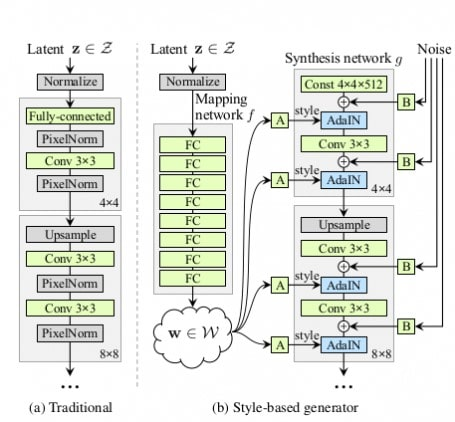

In [1]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision
from torchvision.utils import make_grid
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [3]:
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
image_size = 128
LR = 1e-3
BATCH_SIZES = [64, 64, 64, 32, 32]
CHANNELS_IMG = 3
Z_DIM = 128
W_DIM = 128
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [15] * len(BATCH_SIZES)

In [4]:
#get address such as C:\\(folder with you notebook)
dir = os.path.abspath(os.curdir)
# i suppose what your image folders placed in datasets directory 
data_dir=os.path.join(dir, r"\Users\user\images\train")

In [5]:
DATASET = data_dir
 

In [6]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset


In [7]:
def check_loader():
    loader,_ = get_loader(image_size)
    cloth ,_ = next(iter(loader))
    _, ax = plt.subplots(2,3, figsize=(8,5))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(2):
        for kk in range(3):
            
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
            ind += 1
#check_loader()

In [8]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1, 1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/32]




class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias




class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)




class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

    
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias
    
    
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

In [9]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [11]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [14]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [15]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [16]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha


In [17]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LR, betas=(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1

Curent image size: 4
Epoch [1/ 15


100%|███████████████████████████████████████████████████| 148/148 [02:10<00:00,  1.13it/s, gp=0.108, loss_critic=-2.29]


Epoch [2/ 15


100%|█████████████████████████████████████████████████████| 148/148 [01:55<00:00,  1.28it/s, gp=0.0496, loss_critic=-1]


Epoch [3/ 15


100%|██████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.0168, loss_critic=-.418]


Epoch [4/ 15


100%|██████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.0145, loss_critic=-.347]


Epoch [5/ 15


100%|███████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.008, loss_critic=-.574]


Epoch [6/ 15


100%|██████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.0172, loss_critic=-.137]


Epoch [7/ 15


100%|████████████████████████████████████████████████| 148/148 [01:55<00:00,  1.29it/s, gp=0.00941, loss_critic=-.0308]


Epoch [8/ 15


100%|███████████████████████████████████████████████████| 148/148 [01:55<00:00,  1.28it/s, gp=0.013, loss_critic=-.166]


Epoch [9/ 15


100%|█████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.0124, loss_critic=0.0419]


Epoch [10/ 15


100%|██████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.0115, loss_critic=-.158]


Epoch [11/ 15


100%|█████████████████████████████████████████████████| 148/148 [01:54<00:00,  1.29it/s, gp=0.00946, loss_critic=-.332]


Epoch [12/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:00<00:00,  1.22it/s, gp=0.00695, loss_critic=-.235]


Epoch [13/ 15


100%|██████████████████████████████████████████████████| 148/148 [01:56<00:00,  1.27it/s, gp=0.00628, loss_critic=-.28]


Epoch [14/ 15


100%|██████████████████████████████████████████████████| 148/148 [01:57<00:00,  1.26it/s, gp=0.0104, loss_critic=-.224]


Epoch [15/ 15


100%|██████████████████████████████████████████████████| 148/148 [02:02<00:00,  1.21it/s, gp=0.0064, loss_critic=-.131]


Curent image size: 8
Epoch [1/ 15


100%|██████████████████████████████████████████████████| 148/148 [02:38<00:00,  1.07s/it, gp=0.0164, loss_critic=-1.11]


Epoch [2/ 15


100%|██████████████████████████████████████████████████| 148/148 [02:34<00:00,  1.04s/it, gp=0.0076, loss_critic=-.998]


Epoch [3/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:28<00:00,  1.01s/it, gp=0.00669, loss_critic=-.136]


Epoch [4/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:29<00:00,  1.01s/it, gp=0.0228, loss_critic=-.0282]


Epoch [5/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:29<00:00,  1.01s/it, gp=0.00893, loss_critic=-.333]


Epoch [6/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:28<00:00,  1.00s/it, gp=0.00716, loss_critic=-.519]


Epoch [7/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:29<00:00,  1.01s/it, gp=0.00577, loss_critic=-.505]


Epoch [8/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:29<00:00,  1.01s/it, gp=0.00766, loss_critic=-.396]


Epoch [9/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:30<00:00,  1.01s/it, gp=0.00407, loss_critic=-.511]


Epoch [10/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:29<00:00,  1.01s/it, gp=0.00568, loss_critic=-.245]


Epoch [11/ 15


100%|██████████████████████████████████████████████████| 148/148 [02:30<00:00,  1.01s/it, gp=0.0088, loss_critic=-.315]


Epoch [12/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:29<00:00,  1.01s/it, gp=0.00642, loss_critic=-.362]


Epoch [13/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it, gp=0.00844, loss_critic=-.165]


Epoch [14/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:30<00:00,  1.01s/it, gp=0.00475, loss_critic=-.255]


Epoch [15/ 15


100%|█████████████████████████████████████████████████| 148/148 [02:30<00:00,  1.01s/it, gp=0.00621, loss_critic=-.156]


Curent image size: 16
Epoch [1/ 15


100%|█████████████████████████████████████████████████| 148/148 [04:34<00:00,  1.85s/it, gp=0.00356, loss_critic=-.601]


Epoch [2/ 15


100%|█████████████████████████████████████████████████| 148/148 [04:40<00:00,  1.90s/it, gp=0.00674, loss_critic=-1.06]


Epoch [3/ 15


100%|█████████████████████████████████████████████████| 148/148 [05:08<00:00,  2.09s/it, gp=0.00706, loss_critic=-1.61]


Epoch [4/ 15


100%|█████████████████████████████████████████████████| 148/148 [05:01<00:00,  2.04s/it, gp=0.00669, loss_critic=-1.27]


Epoch [5/ 15


100%|██████████████████████████████████████████████████| 148/148 [04:59<00:00,  2.02s/it, gp=0.0051, loss_critic=-.999]


Epoch [6/ 15


100%|█████████████████████████████████████████████████| 148/148 [04:59<00:00,  2.02s/it, gp=0.00507, loss_critic=-1.08]


Epoch [7/ 15


100%|██████████████████████████████████████████████████| 148/148 [05:01<00:00,  2.04s/it, gp=0.0076, loss_critic=-1.04]


Epoch [8/ 15


100%|█████████████████████████████████████████████████| 148/148 [05:00<00:00,  2.03s/it, gp=0.00592, loss_critic=-.806]


Epoch [9/ 15


100%|█████████████████████████████████████████████████| 148/148 [05:00<00:00,  2.03s/it, gp=0.00363, loss_critic=-.878]


Epoch [10/ 15


100%|█████████████████████████████████████████████████| 148/148 [05:00<00:00,  2.03s/it, gp=0.00772, loss_critic=-1.34]


Epoch [11/ 15


100%|█████████████████████████████████████████████████| 148/148 [04:59<00:00,  2.03s/it, gp=0.00638, loss_critic=-1.61]


Epoch [12/ 15


100%|████████████████████████████████████████████████████| 148/148 [05:00<00:00,  2.03s/it, gp=0.00782, loss_critic=-1]


Epoch [13/ 15


100%|██████████████████████████████████████████████████| 148/148 [04:59<00:00,  2.03s/it, gp=0.00739, loss_critic=-.88]


Epoch [14/ 15


100%|██████████████████████████████████████████████████| 148/148 [04:59<00:00,  2.02s/it, gp=0.0107, loss_critic=-1.02]


Epoch [15/ 15


100%|█████████████████████████████████████████████████| 148/148 [04:59<00:00,  2.03s/it, gp=0.00237, loss_critic=-.673]


Curent image size: 32
Epoch [1/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:45<00:00,  1.57s/it, gp=0.00704, loss_critic=-.155]


Epoch [2/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:36<00:00,  1.54s/it, gp=0.00544, loss_critic=-2.45]


Epoch [3/ 15


100%|██████████████████████████████████████████████████| 296/296 [07:37<00:00,  1.54s/it, gp=0.0128, loss_critic=-1.29]


Epoch [4/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:36<00:00,  1.54s/it, gp=0.00935, loss_critic=-1.76]


Epoch [5/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:36<00:00,  1.54s/it, gp=0.00812, loss_critic=-1.39]


Epoch [6/ 15


100%|██████████████████████████████████████████████████| 296/296 [07:39<00:00,  1.55s/it, gp=0.0174, loss_critic=-2.91]


Epoch [7/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:37<00:00,  1.55s/it, gp=0.00413, loss_critic=-.564]


Epoch [8/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:36<00:00,  1.54s/it, gp=0.00689, loss_critic=-1.59]


Epoch [9/ 15


100%|██████████████████████████████████████████████████| 296/296 [07:36<00:00,  1.54s/it, gp=0.0121, loss_critic=-1.96]


Epoch [10/ 15


100%|██████████████████████████████████████████████████| 296/296 [07:37<00:00,  1.54s/it, gp=0.00612, loss_critic=-1.8]


Epoch [11/ 15


100%|███████████████████████████████████████████████████| 296/296 [07:37<00:00,  1.55s/it, gp=0.0196, loss_critic=-1.5]


Epoch [12/ 15


100%|█████████████████████████████████████████████████| 296/296 [07:38<00:00,  1.55s/it, gp=0.00503, loss_critic=-1.85]


Epoch [13/ 15


100%|█████████████████████████████████████████████████| 296/296 [08:23<00:00,  1.70s/it, gp=0.00532, loss_critic=-1.19]


Epoch [14/ 15


100%|██████████████████████████████████████████████████| 296/296 [08:40<00:00,  1.76s/it, gp=0.00827, loss_critic=-1.5]


Epoch [15/ 15


100%|██████████████████████████████████████████████████| 296/296 [08:37<00:00,  1.75s/it, gp=0.0205, loss_critic=-2.64]


Curent image size: 64
Epoch [1/ 15


100%|██████████████████████████████████████████████████| 296/296 [21:22<00:00,  4.33s/it, gp=0.0111, loss_critic=-4.81]


Epoch [2/ 15


100%|██████████████████████████████████████████████████| 296/296 [22:12<00:00,  4.50s/it, gp=0.0246, loss_critic=-3.15]


Epoch [3/ 15


100%|███████████████████████████████████████████████████| 296/296 [23:39<00:00,  4.80s/it, gp=0.0334, loss_critic=-2.6]


Epoch [4/ 15


100%|███████████████████████████████████████████████████| 296/296 [24:16<00:00,  4.92s/it, gp=0.0238, loss_critic=-4.8]


Epoch [5/ 15


100%|██████████████████████████████████████████████████| 296/296 [22:11<00:00,  4.50s/it, gp=0.0247, loss_critic=-1.75]


Epoch [6/ 15


100%|███████████████████████████████████████████████████| 296/296 [19:47<00:00,  4.01s/it, gp=0.037, loss_critic=-5.34]


Epoch [7/ 15


100%|██████████████████████████████████████████████████| 296/296 [25:19<00:00,  5.13s/it, gp=0.0266, loss_critic=-4.47]


Epoch [8/ 15


100%|██████████████████████████████████████████████████| 296/296 [42:10<00:00,  8.55s/it, gp=0.0417, loss_critic=-.744]


Epoch [9/ 15


100%|██████████████████████████████████████████████████| 296/296 [37:44<00:00,  7.65s/it, gp=0.0254, loss_critic=-1.15]


Epoch [10/ 15


100%|██████████████████████████████████████████████████| 296/296 [40:39<00:00,  8.24s/it, gp=0.0432, loss_critic=-2.11]


Epoch [11/ 15


100%|███████████████████████████████████████████████████| 296/296 [34:14<00:00,  6.94s/it, gp=0.018, loss_critic=-3.27]


Epoch [12/ 15


100%|██████████████████████████████████████████████████| 296/296 [35:42<00:00,  7.24s/it, gp=0.0324, loss_critic=-3.03]


Epoch [13/ 15


100%|███████████████████████████████████████████████████| 296/296 [39:28<00:00,  8.00s/it, gp=0.045, loss_critic=-3.07]


Epoch [14/ 15


100%|██████████████████████████████████████████████████| 296/296 [31:09<00:00,  6.32s/it, gp=0.0142, loss_critic=-3.98]


Epoch [15/ 15


100%|██████████████████████████████████████████████████| 296/296 [30:06<00:00,  6.10s/it, gp=0.0222, loss_critic=-5.19]


In [18]:
torch.save(gen, "genStyle.pth")

In [19]:
generate_examples(gen, step, n=100)